# Test Frequency Methods on wave equation $u_{tt} = c^2 \triangle u$
Compare Frequency Regression, Frequency Fit and PDE-FIND on the transport equaton.

In [1]:
# Packages
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import scipy.linalg
import statsmodels.api as sm
import itertools
import pysindy as ps
import pandas as pd

from scipy.optimize import minimize
from scipy.fft import fftn, ifftn, fftfreq,fft

from ipynb.fs.full.frequency_method_functions import *

In [2]:
#L_2 norm for parameter lists
def distance_para(lista,listb):
    return np.sqrt( np.square(np.array(lista)-np.array(listb)).sum() ) 

#Revert torch parameter list back to list, so distance_para calc is possible
def revert_torchparameterlist_tolist(parameter_list):
    for i in range(len(parameter_list)):
        parameter_list[i]=parameter_list[i].detach().numpy()
    parameter_list=parameter_list
    return parameter_list

### Wave equation: $u_{tt} = c^2 \triangle u$. 
d'Alembert's formula for $u(x,0) = f(x), u_t(x,0) = g(x)$ and $x \in \mathbb{R}$
$$ u(x,t) = \frac{f(x-ct)+f(x+ct)}{2} + \frac{1}{2c} \int_{x-ct}^{x+ct} g(s) ds $$

In [3]:
#Create dataframes to save data
c = 3
#filepath where you want to save the files
filepath=r"/home/math/hauger/Dokumente/Bachelor-Arbeit/results_data/wave_equation"
noise_df_pdefind = pd.DataFrame(index=range(0,11),columns=["parameters","standard deviation","distance","eps"])
noise_df_regr = pd.DataFrame(index=range(0,11),columns=["parameters","standard deviation","distance","eps"])
noise_df_curve = pd.DataFrame(index=range(0,11),columns=["parameters","standard deviation","distance","eps"])

real_para_pdefind = [[0,c*c]]
real_para_regr = [0,0,c*c]
real_para_curve = [0,0,c*c]

list_para_pdefind =[]
list_para_regr=[]
list_para_curve =[]

In [4]:
T,X,t,x= create_data_2d(0,2,5,100,100)
u = np.sin(X-c*T)+np.sin(X+c*T) + 4*X*T

para_regr = frequency_method_regr(u,[x,t],order=2,time_deriv=2)
print("Real Coefficients")
print("u,u_x,u_xx")
print((0,0,c*c))
print("Regression")
print(para_regr)
print("PDE-Find")
para_find =pde_find_sec_timederiv(u,t,x,order=2)

Real Coefficients
u,u_x,u_xx
(0, 0, 9)
Regression
[-2.60396460e-02 -5.42277407e-06  9.01075217e+00]
PDE-Find
(u)' = 9.000 u_11


CurveFit


/home/math/hauger/anaconda3/envs/ba/lib/python3.9/site-packages/torch/autograd/__init__.py:154: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1648016052946/work/aten/src/ATen/native/Copy.cpp:244.)
  Variable._execution_engine.run_backward(


999 27.13729274894402
[Parameter containing:
tensor([2.4175], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([0.7054], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([0.1812], dtype=torch.float64, requires_grad=True)]
1999 11.558407871094241
[Parameter containing:
tensor([1.0325], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([0.1981], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-0.0034], dtype=torch.float64, requires_grad=True)]
2999 11.869682694132853
[Parameter containing:
tensor([0.8620], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([0.2133], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-0.0049], dtype=torch.float64, requires_grad=True)]
3999 2.0559946606473227
[Parameter containing:
tensor([0.4769], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.9829e-11], dtype=torch.float64, requires_grad=True), Param

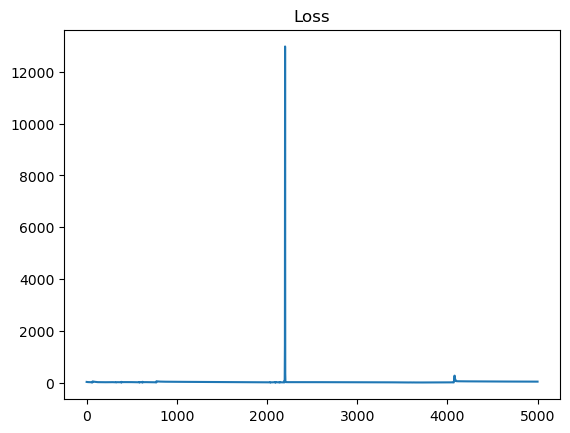

[Parameter containing:
tensor([0.7236], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([-0.7016], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([0.3043], dtype=torch.float64, requires_grad=True)]


In [5]:
print("Curve Fit")
para_curve = frequency_method_curvefit(u,T,[x],ax=[0],order=2,print_loss=True,epochs=5000,time_deriv=2)
print(para_curve)

In [6]:
#Save Data
noise_df_pdefind.loc[0,["standard deviation","eps","distance"]]=[0.0,0.0,distance_para(para_find,real_para_pdefind)]
noise_df_pdefind.at[0,"parameters"]=para_find

noise_df_regr.loc[0,["standard deviation","eps","distance"]]=[0.0,0.0,distance_para(para_regr,real_para_regr)]
noise_df_regr.at[0,"parameters"]=para_regr

para_curve=np.array(revert_torchparameterlist_tolist(para_curve)).reshape(3)
noise_df_curve.loc[0,["standard deviation","eps","distance"]]=[0.0,0.0,distance_para(para_curve,real_para_curve)]
noise_df_curve.at[0,"parameters"]=para_curve

list_para_pdefind.append(para_find)
list_para_regr.append(para_regr)
list_para_curve.append(para_curve)

#### Add noise and save results

#### 1. Calculate results for Frequency Regression and PDE-FIND with noise

In [7]:
u_rms = np.sqrt(np.mean(u*u))
eps = 1e-10
std_deviation = eps*u_rms

for i in range (10):
    noise = np.random.normal(0,std_deviation,u.shape)
    u_noise = u.copy()+noise
    #Calculate parameters
    para_pdefind = pde_find_sec_timederiv(u_noise,t,x,order=2,print_model=False)
    para_regr = frequency_method_regr(u_noise,[x,t],order=2,time_deriv=2)
    #Save std_dev, distance, eps in dataframe
    noise_df_pdefind.loc[i+1,["standard deviation","distance","eps"]] = [std_deviation,
                                                                       distance_para(para_pdefind,real_para_pdefind)
                                                                      ,eps]
    noise_df_regr.loc[i+1,["standard deviation","distance","eps"]] = [std_deviation,
                                                                       distance_para(para_regr,real_para_regr)
                                                                      ,eps]
    #Save parameters
    list_para_pdefind.append(para_pdefind)
    list_para_regr.append(para_regr)
    noise_df_pdefind.at[i+1,"parameters"]=para_pdefind
    noise_df_regr.at[i+1,"parameters"]=para_regr
    
    #Update noise
    eps *=10
    std_deviation *=10

#### 2. Calculate results for Frequency Fit with noise

In [8]:
u_rms = np.sqrt(np.mean(u*u))
eps = 1e-10
std_deviation = eps*u_rms

for i in range (10):
    noise = np.random.normal(0,std_deviation,u.shape)
    u_noise = u.copy()+noise
    #Calculate parameters
    para_curve=frequency_method_curvefit(u_noise,T,[x],ax=[0],order=2,print_loss=False,epochs=500)
    para_curve=np.array(revert_torchparameterlist_tolist(para_curve)).reshape(3)
    #Save std_dev, distance, eps in dataframe
    noise_df_curve.loc[i+1,["standard deviation","distance","eps"]] = [std_deviation,
                                                                       distance_para(para_curve,real_para_curve)
                                                                      ,eps]
    #Save parameters
    list_para_curve.append(para_curve)
    noise_df_curve.at[i+1,"parameters"]=para_curve
    
    #Update noise
    eps *=10
    std_deviation *=10

#### Plot noise

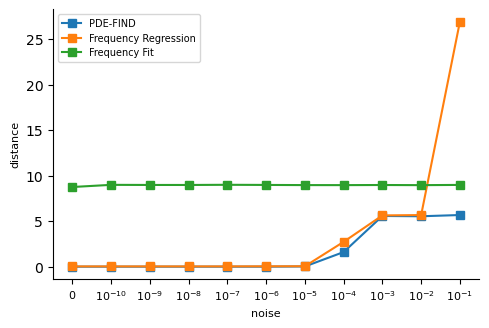

In [9]:
plt.figure(figsize=(5.5,3.5))
mysize=8
xticks=["$\mathregular{0}$"]
for i in range(10):
    xticks.append("$\mathregular{10^{"+str(-10+i)+"}}$")

ax=plt.subplot(111)
default_x_ticks = range(len(xticks))
ax.plot(default_x_ticks,noise_df_pdefind["distance"],'s-',color='tab:blue',label = 'PDE-FIND')
ax.plot(default_x_ticks,noise_df_regr["distance"],'s-',color='tab:orange',label='Frequency Regression')
ax.plot(default_x_ticks,noise_df_curve["distance"],'s-',color='tab:green',label='Frequency Fit')
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
plt.xlabel("noise",size=mysize)
plt.ylabel("distance",size=mysize)
plt.xticks(default_x_ticks, xticks,size=mysize)
plt.legend(loc=2,prop={'size': 7})
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.show()

#### Print parameters with noise: 

PDE-FIND

In [10]:
for i in range(len(list_para_pdefind)):
    print("Noise "+str(i)+": "+str(list_para_pdefind[i])) 

Noise 0: [[-5.35215669e-15  9.00016472e+00]]
Noise 1: [[-1.19670793e-09  9.00016475e+00]]
Noise 2: [[-3.69527297e-08  9.00016489e+00]]
Noise 3: [[-5.27650166e-07  9.00016496e+00]]
Noise 4: [[-3.02534092e-07  9.00010564e+00]]
Noise 5: [[7.65421221e-05 9.00005202e+00]]
Noise 6: [[-1.18630070e-03  8.97619828e+00]]
Noise 7: [[-0.00943138  7.39459523]]
Noise 8: [[0.01718179 3.42928795]]
Noise 9: [[0.41308051 3.4761954 ]]
Noise 10: [[-1.35939665  3.49030953]]


Frequency Regression

In [11]:
for i in range(len(list_para_regr)):
    print("Noise "+str(i)+": "+str(list_para_regr[i])) 

Noise 0: [-2.60396460e-02 -5.42277407e-06  9.01075217e+00]
Noise 1: [-2.60402592e-02 -2.59934353e-06  9.01079455e+00]
Noise 2: [-2.60394083e-02  6.86287634e-06  9.01077008e+00]
Noise 3: [-2.60239495e-02  5.47421617e-05  9.01060783e+00]
Noise 4: [-2.64684788e-02 -8.30346703e-05  9.01424325e+00]
Noise 5: [-2.37515629e-02  5.38506363e-04  9.03214208e+00]
Noise 6: [-3.66377072e-02 -4.40210054e-04  9.02846638e+00]
Noise 7: [-0.07415747  0.01268871  6.27190842]
Noise 8: [-0.19088608 -0.08739329  3.37143474]
Noise 9: [-0.18286611  1.07321635  3.43498491]
Noise 10: [-26.25527467  -2.06762196   3.42366421]


Frequency Fit

In [12]:
for i in range(len(list_para_curve)):
    print("Noise "+str(i)+": "+str(list_para_curve[i].reshape(3))) 

Noise 0: [ 0.72359478 -0.70162427  0.30433121]
Noise 1: [ 9.70581541e-01 -6.43153297e-11  6.15931116e-02]
Noise 2: [0.92960961 0.10382592 0.0702724 ]
Noise 3: [ 9.40657110e-01 -4.76105354e-10  7.25527839e-02]
Noise 4: [1.05564462e+00 1.37522241e-08 6.53965082e-02]
Noise 5: [ 1.01290853e+00 -1.76565547e-07  7.62057393e-02]
Noise 6: [9.38602267e-01 1.22774753e-06 8.53898020e-02]
Noise 7: [1.00201267e+00 1.70093688e-05 9.56151573e-02]
Noise 8: [9.65983428e-01 7.68807618e-05 7.82792616e-02]
Noise 9: [0.65109551 0.00364698 0.06549326]
Noise 10: [ 0.88111955 -0.01243978  0.05979133]


## Save data

In [13]:
#Save data in csv frame
noise_df_pdefind.to_csv(filepath+"/noise_pdefind.csv",sep=';')
noise_df_regr.to_csv(filepath+"/noise_regression.csv",sep=';')
noise_df_curve.to_csv(filepath+"/noise_curve.csv",sep=';')

### Frequency Fit: Perform several times
Because Frequncy Fit depending on the random initialising of parameters will calculate differernt results,
we perform Frequency Fit 20 times and then calculate the mean and standard deviation of the computed parameters.
We will perform this without noise and with noise $10^{-5}$

In [14]:
c=3
T,X,t,x= create_data_2d(0,2,5,100,100)
u = np.sin(X-c*T)+np.sin(X+c*T) + 4*X*T

iter_num =20
number_para = 3
#Create dataframe for saving data
df_curve_iter = pd.DataFrame(index=range(iter_num),columns=["parameters","parameters with noise"])
df_curve_iter_stdmean=pd.DataFrame(index=range(number_para),columns = ["mean","std","mean noise","std noise"])

In [15]:
#without noise
para_curve_fit_median = []
for i in range(iter_num):
    para_curve = frequency_method_curvefit(u,T,[x],ax=[0],order=2,print_loss=False,epochs=500,time_deriv=2)
    para_curve=np.array(revert_torchparameterlist_tolist(para_curve)).reshape(number_para)
    df_curve_iter.at[i,"parameters"]=para_curve
    para_curve_fit_median.append(para_curve) 

In [16]:
#with noise
para_curve_fit_median_noise = []
u_rms = np.sqrt(np.mean(u*u))
eps = 1e-5
std_deviation = eps*u_rms
noise = np.random.normal(0,std_deviation,u.shape)
u_noise = u.copy()+noise
for i in range(iter_num):
    para_curve = frequency_method_curvefit(u_noise,T,[x],ax=[0],order=2,print_loss=False,epochs=500,time_deriv=2)
    para_curve=np.array(revert_torchparameterlist_tolist(para_curve)).reshape(number_para)
    df_curve_iter.at[i,"parameters with noise"]=para_curve
    para_curve_fit_median_noise.append(para_curve) 

#### Save results

In [17]:
mean = np.zeros(number_para)
std = np.zeros(number_para)
mean_noise = mean.copy()
std_noise = std.copy()
for i in range(len(mean)):
    #no noise
    para = [v[i] for v in para_curve_fit_median]
    mean[i] = np.mean(para)
    std[i] = np.std(para)
    #with noiese
    para_noise = [v[i] for v in para_curve_fit_median_noise]
    mean_noise[i] = np.mean(para_noise)
    std_noise[i] = np.std(para_noise)

In [27]:
#Save mean and standard deviation in dataframe
df_curve_iter_stdmean["mean"]=mean
df_curve_iter_stdmean["std"]=std
df_curve_iter_stdmean["mean noise"]=mean_noise
df_curve_iter_stdmean["std noise"]=std_noise

#### Print parameters without noise: 

In [21]:
para_curve_fit_median

[array([ 0.48203432,  0.08683503, -0.09203311]),
 array([ 0.5370496 , -0.1458299 , -0.15341582]),
 array([ 1.70206907,  0.46310605, -0.01006694]),
 array([ 0.53680147, -0.06214446, -0.05845854]),
 array([ 0.64458587,  0.14368356, -0.10704918]),
 array([ 1.45204613,  0.37151625, -0.00755886]),
 array([ 0.53964118, -0.16465128, -0.07808125]),
 array([ 0.46898727,  0.13530333, -0.14667994]),
 array([ 0.60638306, -0.14964061, -0.11498083]),
 array([ 0.43667257, -0.0252464 , -0.06027787]),
 array([ 1.68623839, -0.51864342,  0.15399358]),
 array([ 0.40063547, -0.01717717, -0.0163656 ]),
 array([ 0.58465657, -0.16520689, -0.08851167]),
 array([ 0.49565262, -0.08779484, -0.01222039]),
 array([ 0.48143918, -0.0563566 , -0.00625451]),
 array([ 0.55730357, -0.10605186, -0.07228787]),
 array([ 2.05046552, -0.62305107,  0.12945666]),
 array([ 0.55088133,  0.10335117, -0.09526559]),
 array([ 1.2357232 ,  0.3474589 , -0.00758531]),
 array([ 0.50689948, -0.04385726, -0.0983532 ])]

#### Print parameters with noise: 

In [22]:
para_curve_fit_median_noise

[array([ 0.53711297,  0.06331347, -0.06369326]),
 array([0.63212224, 0.36200445, 0.17995608]),
 array([ 0.59623271,  0.11053973, -0.09582153]),
 array([ 0.9470136 ,  0.93747845, -0.09459959]),
 array([ 0.66211429, -0.13418872, -0.01599292]),
 array([ 0.54604302,  0.0456167 , -0.11512092]),
 array([ 1.88750291, -0.47690249,  0.03986595]),
 array([ 1.97415251, -0.57543565,  0.0905252 ]),
 array([ 0.57863328, -0.01960772, -0.02491853]),
 array([ 0.4991187 , -0.00210782, -0.07259604]),
 array([ 0.49529329, -0.0098271 , -0.06105234]),
 array([ 0.4983613 ,  0.02380553, -0.08707114]),
 array([ 0.47168795, -0.04379076, -0.02022746]),
 array([ 0.55804787, -0.01525259, -0.06439864]),
 array([ 0.60632836, -0.13907347, -0.04208468]),
 array([ 0.58785096, -0.20341524, -0.02844931]),
 array([ 0.50481287, -0.03600698, -0.00169503]),
 array([ 0.57341209, -0.12404147, -0.12694735]),
 array([2.66544894, 1.34472164, 0.25887286]),
 array([ 0.49391496, -0.01200793, -0.08200139])]

## Save data

In [29]:
#Save data in csv frame
df_curve_iter.to_csv(filepath+"/curve_iter.csv",sep=';')
df_curve_iter_stdmean.to_csv(filepath+"/curve_iter_meanstd.csv",sep=';')